In [25]:
import sys
sys.path.append('../..')

In [26]:
import numpy

def Dx(image: numpy.ndarray) -> numpy.ndarray:

    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(
        shape=(nb_rows, nb_cols),
        dtype=numpy.double
    )

    image_derivated[:, 1:nb_cols] = \
        image[:, 1:nb_cols] - image[:, 0:nb_cols-1]

    image_derivated[:, 0] = image[:, 0] - image[:, nb_cols-1]

    return image_derivated

def Dy(image: numpy.ndarray) -> numpy.ndarray:
    
    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(
        shape=(nb_rows, nb_cols),
        dtype=numpy.double
    )
    
    image_derivated[1:nb_rows, :] = \
        image[1:nb_rows, :] - image[0:nb_rows-1, :]

    image_derivated[0, :] = image[0, :] - image[nb_rows-1, :]

    return image_derivated

def Dxt(image: numpy.ndarray) -> numpy.ndarray:

    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(
        shape=(nb_rows, nb_cols),
        dtype=numpy.double
    )
    
    image_derivated[:, 0:nb_cols-1] = \
        image[:, 0:nb_cols-1] - image[:, 1:nb_cols]

    image_derivated[:, nb_cols-1] = image[:, nb_cols-1] - image[:, 0]

    return image_derivated


def Dyt(image: numpy.ndarray) -> numpy.ndarray:
    
    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(
        shape=(nb_rows, nb_cols),
        dtype=numpy.double
    )
    
    image_derivated[0:nb_rows-1, :] = \
        image[0:nb_rows-1, :] - image[1:nb_rows, :]

    image_derivated[nb_rows-1, :] = image[nb_rows-1, :] - image[0, :]

    return image_derivated

def shrink2_v1(x, y, lamda):

    s = numpy.sqrt(x*numpy.conj(x)+y*numpy.conj(y))
    ss = s-lamda
    ss = ss*(ss>0)

    s=s+lamda
    ss=ss/s

    xs=ss*x
    ys=ss*y

    return xs, ys

def shrink2_v2(x, y, lamda):

    s = x + y*1j
    ss = numpy.sign(s) * numpy.where(0 < numpy.abs(s)-lamda, numpy.abs(s)-lamda, 0)
    xs=numpy.real(ss)
    ys=numpy.imag(ss)

    return xs, ys

## CMST_SegMain

In [27]:
import lasp.filters.linear
import lasp.noise
import lasp.io


import pathlib

import scipy.signal
import scipy.io

import matplotlib.pyplot

Img_original = numpy.array(
    matplotlib.pyplot.imread('Boats.bmp'),
    dtype=numpy.double
)

# print('min: {} \t max: {}'.format(
#     numpy.min(Img_original), 
#     numpy.max(Img_original))
# )

h = lasp.filters.linear.gaussian_filter(size=7, sigma=3)

Img_blurred = numpy.array(
    scipy.signal.convolve2d(Img_original, h, mode='same'),
    dtype=numpy.double
)

# print('min: {} \t max: {}'.format(
#     numpy.min(Img_blurred), 
#     numpy.max(Img_blurred))
# )

Img = numpy.copy(Img_blurred)
#Img = lasp.noise.awgn(Img_blurred, snr=20)

#print('min: {} \t max: {}'.format(numpy.min(Img), numpy.max(Img)))

# print(h)
# print(matplotlib.pyplot.imread(path / 'kernel.png'))

In [28]:
path = pathlib.Path('PyVsMat/CMST_SegDeblur')
lasp.io.save(Img, path / 'input.png')
lasp.io.save(h, path / 'kernel.png')

# Save img input and kernel as array for matlab
datas_matlab = {}
datas_matlab['input'] = Img
datas_matlab['kernel'] = h
scipy.io.savemat(path / 'datas_for_matlab.mat', datas_matlab)

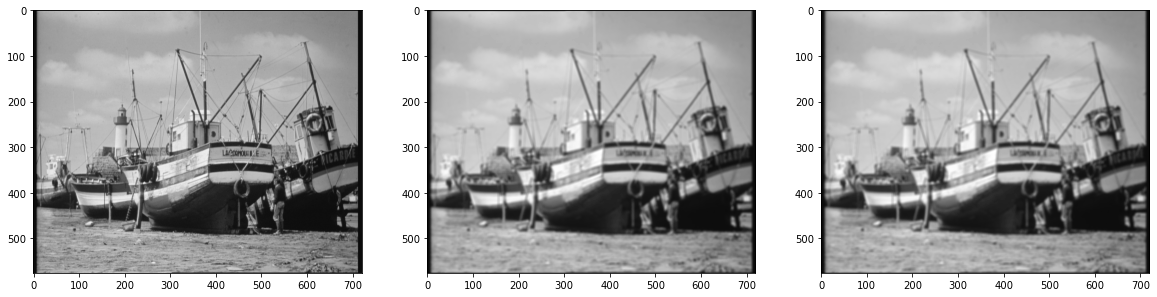

In [30]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(Img_original, cmap='gray')
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(Img_blurred, cmap='gray')
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(Img, cmap='gray')


In [31]:
import numpy
import numpy.linalg


Img = Img - numpy.min(Img)
Img = Img / numpy.max(Img)

LAMBDA = 100
MU = 1
SIGMA = 2

nb_rows, nb_cols = Img.shape
# INitialization
u = numpy.copy(Img) 
wx=numpy.zeros_like(Img)
wy=numpy.zeros_like(Img)
bx=numpy.zeros_like(Img)
by=numpy.zeros_like(Img)

# Build kernel
uker = numpy.zeros_like(Img)
uker[0, 0] = 4
uker[0, 1] = -1
uker[1, 0] = -1
uker[nb_rows-1, 0] = -1
uker[0, nb_cols-1] = -1

# Construct the deblur operator
# flt_blur = numpy.array(numpy.load('motion_15_90.npy'))
flt_blur = h
xLen_flt, yLen_flt = flt_blur.shape
xLen, yLen = Img.shape
ope_blur = numpy.zeros((xLen, yLen))
ope_blur[0:xLen_flt, 0:yLen_flt] = flt_blur

# Shift deblur operator
xLen_flt_1 = int(numpy.round(xLen_flt/2))
yLen_flt_1 = int(numpy.round(yLen_flt/2))
# ope_blur_1 = numpy.pad()
# ope_blur_1 = ope_blur_1[xLen_flt_1+1:xLen+xLen_flt_1+1, yLen_flt_1+1:yLen+yLen_flt_1]
ope_blur_1 = numpy.roll(ope_blur, (1-xLen_flt_1, 1-yLen_flt_1), [0, 1])

uker = LAMBDA*numpy.conj(numpy.fft.fft2(ope_blur_1))*numpy.fft.fft2(ope_blur_1)+(MU+SIGMA)*numpy.fft.fft2(uker)

rhs1fft = LAMBDA*numpy.conj(numpy.fft.fft2(ope_blur_1))*numpy.fft.fft2(Img)


NB_ITERATIONS = 300

error_function = []


for i in range(0, NB_ITERATIONS):

    rhs2 = SIGMA*Dxt(wx-bx)+SIGMA*Dyt(wy-by)
    rhsfft = rhs1fft + numpy.fft.fft2(rhs2)

    u0=numpy.copy(u)
    
    u = numpy.real(numpy.fft.ifft2(rhsfft / uker))
    #u = numpy.fft.ifft2(rhsfft / uker)

   

    err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')
    error_function.append(err)
    # if i%10 == 0:
    #     print('Iterations: {} ! \t error is: {}'.format(i, err))

    # if err < 10**(-4):
    #     break
    
    temp1 = Dx(u)+bx
    temp2 = Dy(u)+by

    # wx, wy = shrink2_v1(temp1, temp2, 1/SIGMA)
    wx, wy = shrink2_v1(temp1, temp2, 1/SIGMA)

    bx=bx+Dx(u)-wx
    by=by+Dy(u)-wy

    #if i == 2:
    #    print('rhs2 :', rhs2[0:3, 0:3])
    #    print('rhsfft :', rhsfft[0:3, 0:3])
    #    print('u :', u[0:3, 0:3])
    #    print('wx :', wx[0:3, 0:3])
    #    print('wy :', wy[0:3, 0:3])
    #    print('bx :', bx[0:3, 0:3])
    #    print('by :', by[0:3, 0:3])

min_u = numpy.min(u)
max_u = numpy.max(u)
u = (u-min_u) / (max_u-min_u)

# mat 5x5 alétaoire
# load(mat)
# difference entre les 2


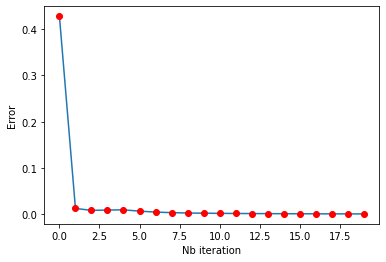

In [32]:
x = numpy.arange(0, NB_ITERATIONS)
y = error_function
matplotlib.pyplot.xlabel(xlabel='Nb iteration')
matplotlib.pyplot.ylabel(ylabel='Error')
_ = matplotlib.pyplot.plot(x[0:20], y[0:20])
_ = matplotlib.pyplot.plot(x[0:20], y[0:20], 'or')

In [36]:
print(y[0:20])

[0.42792694943848686, 0.01255827545374011, 0.008322184857328574, 0.009042210474951427, 0.009444928170766859, 0.00668679659526409, 0.004602969095597457, 0.003412697479048709, 0.0026930798511374918, 0.002214910858222557, 0.0018686078052548502, 0.0016199340167419398, 0.0014278902565183023, 0.0012580432498233937, 0.0011076379932146777, 0.000983764292285791, 0.0008751728961094301, 0.0007997685171923421, 0.0007290438208255623, 0.0006657572212494654]


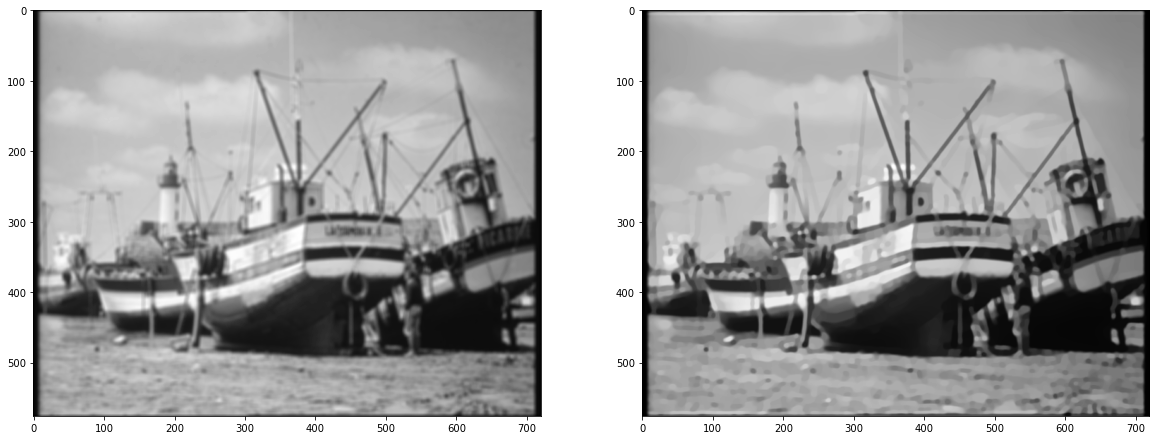

In [9]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.imshow(Img, cmap='gray')
matplotlib.pyplot.subplot(1, 2, 2)

matplotlib.pyplot.imshow(numpy.real(u), cmap='gray')
lasp.io.save(u, path / 'output.png')

In [33]:
# import scipy.io
# a = scipy.io.matlab.loadmat('uu.mat')
# mat_res = numpy.array(a['uu'])
# matplotlib.pyplot.imshow(mat_res, cmap='gray')
# numpy.max(numpy.abs(mat_res-u))

In [34]:
# import lasp.metrics
# lasp.metrics.mean_squared_error(mat_res, u)

In [35]:
# matplotlib.pyplot.imshow(numpy.abs(mat_res-u), cmap='gray')